In [1]:
import numpy as np
import pandas as pd
import sys
import os
import glob
import shutil
import h5py
from itertools import repeat
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_tad_files(input_path):
    gamma_values = np.linspace(1, 1, 1, endpoint = True)
    tad_files = {key: [] for key in gamma_values}
    path =  input_path + '/*'
    filenames = glob.glob(path)
    for gamma, file in zip(gamma_values, filenames):
        tad_files[gamma].append(file)
        
    return tad_files


    
def numeration(size, interaction_type = 'tad'):
    if size%2 == 0:
        dist = np.arange(size//2)
        dist = np.concatenate([dist, dist[::-1]])
    else:
        dist = np.arange((size-1)//2)
        dist = np.concatenate([dist, [size//2], dist[::-1]])
        
    if interaction_type == 'intertad':
        dist = (dist + 1) * (-1)
    return dist



def columns(first_col, second_col, start, end, resolution, interaction_type = 'tad'):
    size = (end-start)/resolution
    col1 = np.arange(start, end, resolution)
    
    if interaction_type != 'skip':
        col2 = numeration(int(size), interaction_type).astype(str)
    else:
        col2 = np.repeat(np.nan, size)

    first_col = np.append(first_col, col1)
    second_col = np.append(second_col, col2)
    return first_col, second_col.astype(str)



def get_distances(data, length, chromosome, resolution):
    first_col = np.array([])
    second_col = np.array([])
    
    bp = 0
    start_bin = int(data[0][1])
    if start_bin != 0:
        first_col, second_col = columns(first_col, second_col, bp, start_bin, resolution, interaction_type = 'skip')
    bp = start_bin

    for row in data:
        start_bin, end_bin = row[1], row[2]
        if bp != start_bin:
            first_col, second_col = columns(first_col, second_col, bp, start_bin, resolution, interaction_type = 'intertad')
        first_col, second_col = columns(first_col, second_col, start_bin, end_bin, resolution, interaction_type = 'tad')
        bp = end_bin

    if (length > bp):
        start, end = bp, length
        first_col, second_col = columns(first_col, second_col, bp, end, resolution, interaction_type = 'skip')
    
    labels = np.repeat([chromosome], len(first_col))
    out = np.vstack((labels, first_col.astype(int), second_col))
    return np.transpose(out) 



In [3]:
def get_numeration(chr_labels, input_path, resolution, chr_length):
    chr_length = np.array(chr_length) * resolution
    tad_files = get_tad_files(input_path)

    dict_md = {key: [] for key in tad_files.keys()}
    chrs_counter = 0
    data = pd.read_csv(tad_files[1][0])
    
    df = pd.DataFrame()
    lbl_total = chr_labels
    for length, label in zip(chr_length, chr_labels):
        data_sub = data.loc[data['Chr'] == label]
        markdown  = get_distances(data_sub.values, length, label, resolution)
        df_chr = pd.DataFrame(markdown)
        df = pd.concat([df, df_chr])
        chrs_counter += 1
        
    dict_md[1].append(df.values)
    dict_md[1].append(lbl_total)

    if chrs_counter == 0:
        print('There are no TADs identified across resolutions and replicates of Hi-C data!')

    return dict_md, tad_files


In [4]:
def optimal_gamma(data):
    samples = data.columns[1:]
    gamma = data.Gamma
    for sample in samples:
        maxindex = data[sample].idxmax()
    
    return round(gamma[maxindex], 2)


def select_optimal_tads(tads, optimal_gamma, samplename):
    dst = check_path('output/', 'optimal_gamma', samplename)
    merged_tads = pd.DataFrame(columns = ['Chr', 'Start', 'End'])
    for src in tads[optimal_gamma]:
        tad = pd.read_csv(src, header = None, names = ['Chr', 'Start', 'End'], sep = '\t')
        tad = tad[::-1]
        tad.End += 1
        merged_tads = pd.concat([merged_tads, tad])
    merged_tads.to_csv(dst + 'domains.tad', header = True, index = False)


def save_stairs(data, index_min, index_max, output_path):
    data = pd.DataFrame(data)
    x_val = np.arange(index_min, index_max, 1)
    data.index = x_val
    data.to_csv(output_path, header = True, index=True)


def nan_array_comparison(func, arr, thresh):
    # https://stackoverflow.com/questions/47340000/how-to-get-rid-of-runtimewarning-invalid-value-encountered-in-greater
    # by Divakar
    bool_arr = ~np.isnan(arr)
    bool_arr[bool_arr] = func(arr[bool_arr], thresh)
    return bool_arr


def progressbar (iteration, total):
    prefix = ' '*21
    suffix = 'complete'
    length = 47
    decimals = 1
    fill = '█'
    
    percent = ('{0:.' + str(decimals) + 'f}').format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    if iteration == total:
        print()

def check_path(path, folder_name, name = None):
    dirName = os.path.join(path, folder_name, name + '/')
    if not os.path.exists(dirName):
        os.makedirs(dirName, exist_ok=True)
    else:
        for old_file in glob.glob(os.path.join(dirName, '*')):
            os.remove(old_file)
    return dirName


def split_chromosome_input(region, resolution):
    region_split = region.split(':')
    try:
        chromosome = region_split[0]
        if len(region_split) == 2:
            coordinates = region_split[1].split('-')
            start_bin = int(coordinates[0].replace(',',''))
            end_bin = int(coordinates[1].replace(',',''))

            start_bin = int(start_bin/resolution)
            end_bin = int(end_bin/resolution)
        else:
            start_bin = 0
            end_bin = None

    except ValueError:
        print('Invalid format of chromosome coordinates!')

    return chromosome, start_bin, end_bin


def get_chipname(chipnames, subfname):
    c = 0
    for name in chipnames:
        f = os.path.split(name)[1].split('.')[0]
        if f == subfname:
            break
        c+=1
    return chipnames[0]


def get_labels(start_bin, end_bin, nticks, resolution):
    interval = (end_bin - start_bin)
    ticks = list(np.linspace(0, interval, nticks).astype(int))
    pos = np.linspace(start_bin, end_bin, nticks) * resolution/1000 # kb
    pos = pos.astype(int).astype(str)
    labels = [i + ' kb' for i in pos]
    return ticks, labels


def check_prefix(vector):
    return ["chr" in chrm for chrm in vector]


def check_chrnames(labels_config, labels):
    if np.any(check_prefix(labels)) and not np.all(check_prefix(labels_config)):
        labels_config = ['chr'+ chrm for chrm in labels_config]
    elif not np.any(check_prefix(labels)) and np.all(check_prefix(labels_config)):   
        labels_config = [chrm[3:] for chrm in labels_config]
        
    if set(labels_config).issubset(set(labels)):
        chrnames = labels_config
    elif len(set(labels).intersection(labels_config)) > 0:
        chrnames = np.array(set(labels).intersection(labels_config))
    else:
        print('ERROR: Specified choromosomes are not found! Please set correct chromosome names in the configuration file.')
        sys.exit(1)
            
    return chrnames


def check_filenames(hic_files, chipseq_files):
    samplenames = [os.path.split(i)[1].split('.')[0] for i in hic_files]
    hic_files_number = len(hic_files)
    chipseq_files_number = len(chipseq_files)
    if hic_files_number != chipseq_files_number:
        if hic_files_number == 1:
            hic_files = np.repeat(hic_files, chipseq_files_number)
            samplenames = [os.path.split(i)[1].split('.')[0] for i in chipseq_files]
        elif chipseq_files_number == 1:
            chipseq_files = np.repeat(chipseq_files, hic_files_number)
        else:
            print("ERROR: Please provide correct number of input Hi-C and ChIP-seq files")
            sys.exit(1)
        
    return np.array(sorted(hic_files)), np.array(sorted(chipseq_files)), np.array(sorted(samplenames))



In [5]:
bedgraph_extensions = ['.bedgraph', '.bedGraph', '.BedGraph', '.bg']
bigwig_extensions = ['.bigwig', '.bigWig', '.BigWig', '.bw']


def equal_sizes(data, chromsize):
    data_size = dict(Counter(data.Chr.values))
    return data_size == chromsize


def binarize_data(data, chromsize, resolution):
    if equal_sizes(data, chromsize) != True:
        df = pd.DataFrame([])
        sizes = np.fromiter(chromsize.values(), dtype = int)
        for chrname, length in zip(np.unique(data.Chr.values), sizes):
            chr_data = data.loc[data.Chr == chrname]
            arr = []
            for i in np.arange(0, resolution*length, resolution):
                d = chr_data.loc[(chr_data.Start < i+resolution) & (chr_data.Start >= i)]
                arr.append([chrname, str(i), str(i+resolution), str(d.Score.mean(skipna=True))])

            arr = np.reshape(arr, (length, 4))
            df = pd.concat([df, pd.DataFrame(arr)])
        data = df
        data.columns = ['Chr', 'Start', 'End', 'Score']
        data.replace(['inf', '-inf'], 'nan', inplace=True)
    
    return data



def get_bedgraph(self):
    df_chip = pd.read_csv(self.path, sep = ' ', comment = 't', header = None, names = ['Chr', 'Start', 'End', 'Score'])

    if self.chrnames != ['']:
        labels = check_chrnames(self.chrnames, np.unique(df_chip.Chr))
        df_chip = df_chip.loc[df_chip['Chr'].isin(labels)]

    df_chip = df_chip.replace('NA', 'nan')
    df_chip.replace(['inf', '-inf'], 'nan', inplace=True)

    df_chip = binarize_data(df_chip, self.chromsize, self.resolution)
    convert_dict = {'Chr': str, 'Start': int, 'End': int, 'Score': float}
    df_chip = df_chip.astype(convert_dict)

    return df_chip



def get_bigwig_file(self):
    import pyBigWig
    bw = pyBigWig.open(self.path)
    if bw.isBigWig() == False:
        print('Incompatible format of ChIP-seq file!')
        sys.exit(1)

    df_chip = pd.DataFrame([])

    for ch in bw.chroms().keys():
        intervals = bw.intervals(ch)
        df_intervals = pd.DataFrame(intervals, columns = ['Start', 'End', 'Score'])
        chr_labels = list(repeat(ch, len(df_intervals.index)))
        df_chr = pd.concat([pd.DataFrame(chr_labels, columns = ['Chr']), df_intervals], axis = 1)
        if df_chip.empty:
            df_chip = df_chr
        else:
            df_chip = pd.concat([df_chip, df_chr])

        convert_dict = {'Chr': str, 'Start': int, 'End': int, 'Score': float}
        df_chip = df_chip.astype(convert_dict)

        if self.chrnames != ['']:
            labels = check_chrnames(self.chrnames, np.unique(df_chip.Chr))
            df_chip = df_chip.loc[df_chip['Chr'].isin(labels)]

        df_chip = binarize_data(df_chip, self.chromsize, self.resolution)

    return df_chip


class ChipSeq:
    def __init__(self, path, set_chromosomes, chromsize, resolution):
        self.path = path
        self.extension = os.path.splitext(path)[1]
        self.chromsize = chromsize
        self.resolution = resolution

        if set_chromosomes != 'None':
            self.chrnames = set_chromosomes.split(',')
        else:  
            self.chrnames = ['']

        accepted_extensions = bedgraph_extensions + bigwig_extensions
        if self.extension not in accepted_extensions:
            print('Incompatible format of ChIP-seq file!')
            sys.exit(1)

    def __call__(self, log2_chip, zscore_chip):
        if self.extension in bedgraph_extensions:
            df_chip = get_bedgraph(self)
        else:
            df_chip = get_bigwig_file(self)
        
        if log2_chip:
            score = df_chip.Score.values
            bool_arr = nan_array_comparison(np.less, score, 1e-10)
            score[bool_arr] = np.nan
            df_chip.Score = np.log2(df_chip.Score.values)
            df_chip = df_chip.replace(np.inf, np.nan)
        
        if zscore_chip:
            df_chip.Score = (df_chip.Score - df_chip.Score.mean()) / df_chip.Score.std(ddof=0)

        return df_chip


In [6]:
def get_stairs(index_data, chip_data, index_min = -5, index_max = 5, acetyl_min = -3, acetyl_max = 5):
    kb_list = np.arange(index_min, index_max, 1)
    gamma_range = index_data.keys()
    dict_amplitudes = {key: None for key in gamma_range}
    dict_stairs = {key: None for key in gamma_range}
    convert_chip = {'Chr': str, 'Start': int, 'End': int, 'Score': float}
    convert_dist = {'Chr': str, 'Bp': int, 'Index': str}
    
    print(gamma_range)
    for gamma in gamma_range:
        df_dist = pd.DataFrame(index_data[1][0], columns = ['Chr', 'Bp', 'Index'])
        chromosomes = index_data[1][1]

        
        df_dist = df_dist.loc[df_dist['Chr'].isin(chromosomes)]
        df_chip = chip_data.loc[chip_data['Chr'].isin(chromosomes)]
        
        df_dist = df_dist.astype(convert_dist)
        df_chip = df_chip.astype(convert_chip)
        
        df_dist = df_dist.sort_values(by = ["Chr", "Bp"])
        df_chip = df_chip.sort_values(by = ["Chr", "Start"])
        
        df_dist.index = np.arange(df_dist.shape[0])
        df_chip.index = np.arange(df_chip.shape[0])
        
        median_val = []
        interTAD = []
        TAD = []
        
        for idx in kb_list:
            row = df_dist.loc[df_dist.Index == str(idx)]
            if row.empty == False:
                bins = row.index.values
                d_chip = df_chip.loc[df_chip.index.isin(bins)]
                acetyl_val = d_chip['Score'].values
                acetyl_val = acetyl_val[~np.isnan(acetyl_val)]
                acetyl_val = acetyl_val[(acetyl_val > acetyl_min) & (acetyl_val < acetyl_max)]
                
                if len(acetyl_val) == 0:
                    median_val.append(np.nan)
                else:
                    median_val.append(np.median(acetyl_val))
                
                if idx <= -1:
                    interTAD = np.append(interTAD, acetyl_val)
                if idx >= 0:
                    TAD = np.append(TAD, acetyl_val)
            else:
                median_val.append(np.nan)
        
        amplitude = np.median(interTAD) - np.median(TAD)
        dict_stairs[1] = np.array(median_val)
        dict_amplitudes[1] = amplitude
    
    return dict_stairs, dict_amplitudes

## ClusterTAD

In [7]:
chip_path = "/Users/dmitriismirnov/Desktop/Skoltech/TADs/Drosophila/GSE62904/Files/BEAF.bedgraph"
ChipSeqLoader = ChipSeq(chip_path, "chr2L,chr2R,chr3L,chr3R,chrX", 
                        {"chr2L":1151, "chr2R":1058, "chr3L":1228, "chr3R":1396, "chrX":1122}, 20000)
chip_data = ChipSeqLoader(True, True)

In [8]:
ind, tads = get_numeration(chr_labels = ["chr2L", "chr2R", "chr3L", "chr3R", "chrX"],
            input_path = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/TAD_tool_comparison/ClusterTAD/",
            resolution = 20000, 
            chr_length = [1151, 1058, 1228, 1396, 1122])

In [9]:
cluster_tad_stairs, amplitudes = get_stairs(ind, chip_data, index_min = -4, index_max = 5, 
                                            acetyl_min = -3, acetyl_max = 5)

dict_keys([1.0])


In [10]:
amplitudes

{1.0: 0.6620897335708665}

## TopDom

In [11]:
ind, tads = get_numeration(chr_labels = ["chr2L", "chr2R", "chr3L", "chr3R", "chrX"],
            input_path = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/TAD_tool_comparison/TopDom/10/",
            resolution = 20000, 
            chr_length = [1151, 1058, 1228, 1396, 1122])

In [12]:
topdom_stairs, amplitudes = get_stairs(ind, chip_data, index_min = -4, index_max = 5, acetyl_min = -3, acetyl_max = 5)

dict_keys([1.0])


In [13]:
amplitudes

{1.0: 0.9679367971269934}

## Caspian

Chebyshev

In [17]:
ind, tads = get_numeration(chr_labels = ["chr2L", "chr2R", "chr3L", "chr3R", "chrX"],
    input_path = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/TAD_tool_comparison/Caspian/Chebyshev/",
    resolution = 20000, 
    chr_length = [1151, 1058, 1228, 1396, 1122])

In [18]:
cheb_stairs, amplitudes = get_stairs(ind, chip_data, index_min = -4, index_max = 5, acetyl_min = -3, acetyl_max = 5)

dict_keys([1.0])


In [19]:
amplitudes

{1.0: 0.08266504201894675}

Euclidian

In [20]:
ind, tads = get_numeration(chr_labels = ["chr2L", "chr2R", "chr3L", "chr3R", "chrX"],
    input_path = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/TAD_tool_comparison/Caspian/Euclidean/",
    resolution = 20000, 
    chr_length = [1151, 1058, 1228, 1396, 1122])

In [21]:
eucl_stairs, amplitudes = get_stairs(ind, chip_data, index_min = -4, index_max = 5, acetyl_min = -3, acetyl_max = 5)

dict_keys([1.0])


In [22]:
amplitudes

{1.0: -0.08672011463546103}

Manhattan

In [23]:
ind, tads = get_numeration(chr_labels = ["chr2L", "chr2R", "chr3L", "chr3R", "chrX"],
    input_path = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/TAD_tool_comparison/Caspian/Manhattan/",
    resolution = 20000, 
    chr_length = [1151, 1058, 1228, 1396, 1122])

In [24]:
manh_stairs, amplitudes = get_stairs(ind, chip_data, index_min = -4, index_max = 5, acetyl_min = -3, acetyl_max = 5)

dict_keys([1.0])


In [25]:
amplitudes

{1.0: 0.12617381813277845}

## Li et al BEAF

In [26]:
prefix = "/Users/dmitriismirnov/Dropbox/Projects/optimalTAD/Results/Li_2015/New/Imputation/"

In [27]:
stairs = pd.read_csv(prefix + "stair.csv")

## Stair calling

In [30]:
stair_dict = {"index" : np.arange(-4,4.1,1).astype("int"), 
              "optimalTAD": stairs.BEAF.values, 
              "ClusterTAD": cluster_tad_stairs[1.0], 
              "TopDom": topdom_stairs[1.0], 
              "Caspian_eucl": eucl_stairs[1.0], 
              "Caspian_manh": manh_stairs[1.0], 
              "Caspian_cheb": cheb_stairs[1.0]}

In [31]:
all_stairs = pd.DataFrame(stair_dict)

optimalTAD

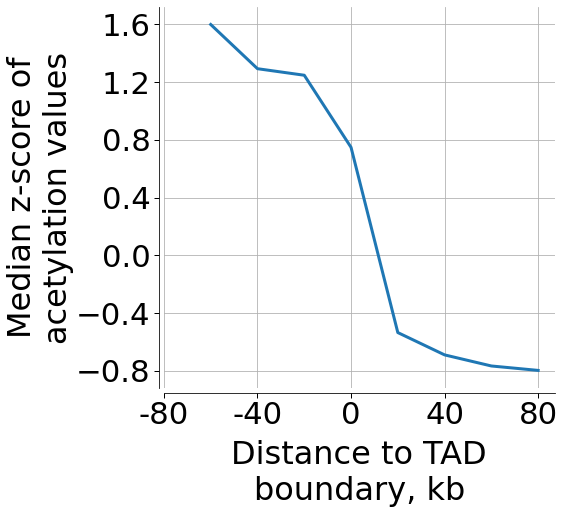

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.set_context("paper", font_scale=3.5)

#my_pal = {"Control 1": "#2b8cbe", "Control 2": "#a6bddb", "Lam-KD 1": "#de2d26", "Lam-KD 2": "#e5a0a0"}
sns.lineplot(data = all_stairs[["index","optimalTAD"]], x = "index", 
             y = "optimalTAD", linewidth = 3)

sns.despine(offset=5, trim=False)
plt.ylabel('Median z-score of\nacetylation values', fontsize = 32, labelpad = 2)
plt.xlabel('Distance to TAD\nboundary, kb', fontsize = 32, labelpad = 10)

plt.yticks(np.arange(-0.8, 1.61, 0.4))

ax.set_xticks([-4, -2,  0,  2,  4])
ax.set_xticklabels([-80,  -40,  0,  40,  80])

plt.grid()

#plt.savefig('../Figures/Comparisons_optimalTAD.png', dpi=350, bbox_inches='tight')

ClusterTAD

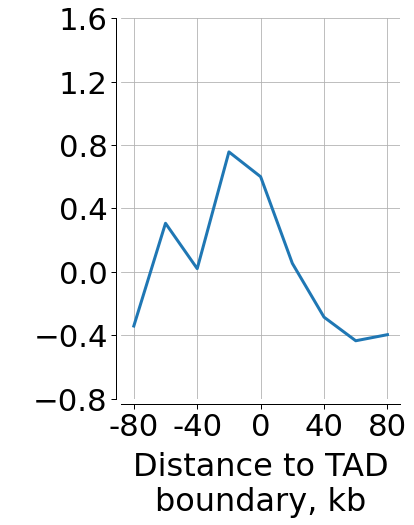

In [33]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.set_context("paper", font_scale=3.5)

#my_pal = {"Control 1": "#2b8cbe", "Control 2": "#a6bddb", "Lam-KD 1": "#de2d26", "Lam-KD 2": "#e5a0a0"}
sns.lineplot(data = all_stairs[["index", "ClusterTAD"]], x = "index", 
             y = "ClusterTAD", linewidth = 3)

sns.despine(offset=5, trim=False)
plt.ylabel(' ', fontsize = 25, labelpad = 2)
plt.xlabel('Distance to TAD\nboundary, kb', fontsize = 32, labelpad = 10)

plt.yticks(np.arange(-0.8, 1.61, 0.4))
ax.set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax.set_xticklabels([-80, -60, -40, -20, 0, 20, 40, 60, 80])

ax.set_xticks([-4, -2,  0,  2,  4])
ax.set_xticklabels([-80,  -40,  0,  40,  80])

plt.grid()

TopDom

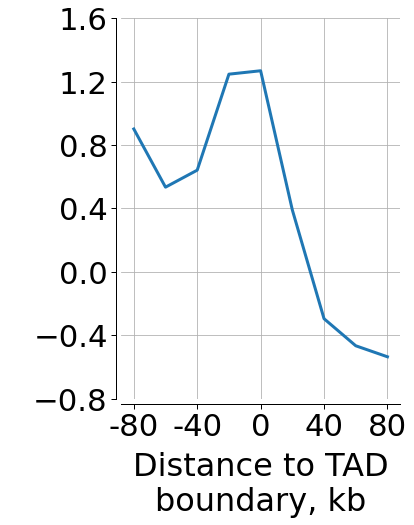

In [34]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.set_context("paper", font_scale=3.5)

#my_pal = {"Control 1": "#2b8cbe", "Control 2": "#a6bddb", "Lam-KD 1": "#de2d26", "Lam-KD 2": "#e5a0a0"}
sns.lineplot(data = all_stairs[["index","TopDom"]], x = "index", 
             y = "TopDom", linewidth = 3)

sns.despine(offset=5, trim=False)
plt.ylabel(' ', fontsize = 25, labelpad = 2)
plt.xlabel('Distance to TAD\nboundary, kb', fontsize = 32, labelpad = 10)

plt.yticks(np.arange(-0.8, 1.61, 0.4))
ax.set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax.set_xticklabels([-80, -60, -40, -20, 0, 20, 40, 60, 80])

ax.set_xticks([-4, -2,  0,  2,  4])
ax.set_xticklabels([-80,  -40,  0,  40,  80])

plt.grid()

In [35]:
df_eucl = all_stairs[["index","Caspian_eucl"]]
df_manh = all_stairs[["index","Caspian_manh"]]
df_cheb = all_stairs[["index","Caspian_cheb"]]

df_eucl.columns = ["index","Value"]
df_manh.columns = ["index","Value"]
df_cheb.columns = ["index","Value"]

df_eucl["Method"] = 'Euclidian'
df_manh["Method"] = 'Manhattan'
df_cheb["Method"] = 'Chebyshev'

df_stairs = pd.concat([df_eucl, df_manh, df_cheb])

<ipython-input-35-a364bea036d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eucl["Method"] = 'Euclidian'
<ipython-input-35-a364bea036d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manh["Method"] = 'Manhattan'
<ipython-input-35-a364bea036d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Caspian

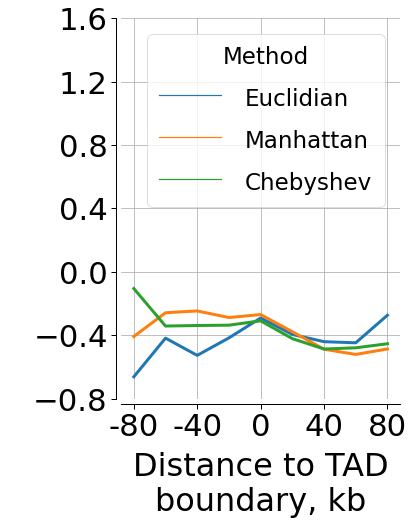

In [37]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.set_context("paper", font_scale=3.5)

#my_pal = {"Control 1": "#2b8cbe", "Control 2": "#a6bddb", "Lam-KD 1": "#de2d26", "Lam-KD 2": "#e5a0a0"}
sns.lineplot(data = df_stairs, x = "index", 
             y = "Value", hue = "Method", linewidth = 3)

sns.despine(offset=5, trim=False)
plt.ylabel(' ', fontsize = 25, labelpad = 2)
plt.xlabel('Distance to TAD\nboundary, kb', fontsize = 32, labelpad = 10)

plt.yticks(np.arange(-0.8, 1.61, 0.4))
ax.set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax.set_xticklabels([-80, -60, -40, -20, 0, 20, 40, 60, 80])
plt.setp(ax.get_legend().get_texts(), fontsize='23') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='23') # for legend title

ax.set_xticks([-4, -2,  0,  2,  4])
ax.set_xticklabels([-80,  -40,  0,  40,  80])

plt.grid()

In [38]:
d = {"Tool": ["optimalTAD", "TopDom", "ClusterTAD", "Caspian Manhattan", "Caspian Chebyshev", "Caspian Euclidian"], 
 "Amplitude": [1.69, 0.96, 0.66, 0.126, 0.082, -0.086]}

d = pd.DataFrame(d)

[Text(0, 0, 'optimalTAD'),
 Text(1, 0, 'TopDom'),
 Text(2, 0, 'ClusterTAD'),
 Text(3, 0, 'Caspian\n(Manhattan)'),
 Text(4, 0, 'Caspian\n(Chebyshev)'),
 Text(5, 0, 'Caspian\n(Euclidian)')]

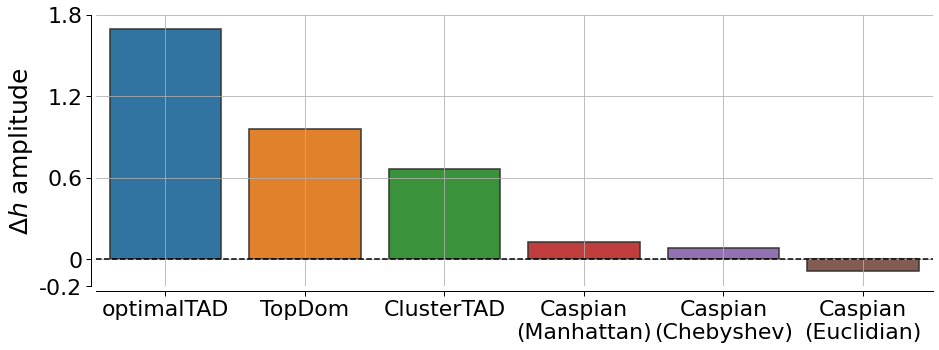

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_context("paper", font_scale=2.5)

b = sns.barplot(x="Tool", y="Amplitude",
                data=d, edgecolor=".2", linewidth=1.5)
sns.despine(offset=5, trim=False)
plt.xlabel('')
plt.ylabel('$\Delta h$ amplitude', fontsize = 25)
ax.set_yticks([-0.2, 0, 0.6, 1.2, 1.8])
ax.set_yticklabels([-0.2, 0, 0.6, 1.2, 1.8])
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.grid()
ax.set_xticklabels(["optimalTAD",  
                    "TopDom", "ClusterTAD", 
                    "Caspian\n(Manhattan)", 
                    "Caspian\n(Chebyshev)", 
                    "Caspian\n(Euclidian)"])